In [ ]:
import re
import math
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# --- 1. Data Loading and Preprocessing ---

def load_data(filepath):
    """Loads data from the SMS Spam Collection file."""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                data.append((parts[0], parts[1]))
    return data

def preprocess(text):
    """
    Preprocesses a single text message.
    - Converts to lowercase
    - Removes punctuation
    - Tokenizes
    - Removes simple English stopwords
    """
    # A simple list of stopwords, as NLTK/spacy are external dependencies.
    stopwords = set([
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
        'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
        'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
        'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
        'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
        'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
        'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
        'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
        'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
        'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
        'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
    ])

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    tokens = text.split()
    return [word for word in tokens if word not in stopwords]

# Load and preprocess data
data = load_data('/content/SMSSpamCollection')
labels = [d[0] for d in data]
texts = [preprocess(d[1]) for d in data]

# Combine for shuffling
combined = list(zip(texts, labels))
np.random.shuffle(combined)
texts, labels = zip(*combined)
texts, labels = np.array(texts, dtype=object), np.array(labels)

In [ ]:
# --- 2. Naive Bayes Classifiers (from scratch) --- [cite: 51]

class NaiveBayesClassifier:
    """Base class for Naive Bayes classifiers."""
    def __init__(self, smoothing=1):
        self.smoothing = smoothing # Add-one (Laplace) smoothing
        self.priors = {}
        self.log_likelihoods = {}
        self.vocab = set()
        self.classes = []

    def fit(self, X_train, y_train):
        raise NotImplementedError

    def predict(self, X_test):
        return [self._predict_single(x) for x in X_test]

    def _predict_single(self, x):
        scores = {cls: self.priors[cls] for cls in self.classes}
        for word in x:
            if word in self.vocab:
                for cls in self.classes:
                    scores[cls] += self.log_likelihoods[cls].get(word, 0)
        return max(scores, key=scores.get)


class MultinomialNB(NaiveBayesClassifier):
    """
    Multinomial Naive Bayes classifier. [cite: 12]
    Features represent word counts.
    """
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        n_samples = len(X_train)

        # Build vocabulary from training data [cite: 29]
        all_words = [word for doc in X_train for word in doc]
        self.vocab = set(all_words)
        vocab_size = len(self.vocab)

        for cls in self.classes:
            X_cls = [X_train[i] for i, label in enumerate(y_train) if label == cls]

            # Calculate log prior using log-probabilities
            self.priors[cls] = math.log(len(X_cls) / n_samples)

            # Calculate log likelihoods
            word_counts = defaultdict(int)
            total_words_in_class = 0
            for doc in X_cls:
                for word in doc:
                    word_counts[word] += 1
                    total_words_in_class += 1

            self.log_likelihoods[cls] = {}
            for word in self.vocab:
                # Laplace smoothing applied here
                numerator = word_counts[word] + self.smoothing
                denominator = total_words_in_class + (vocab_size * self.smoothing)
                self.log_likelihoods[cls][word] = math.log(numerator / denominator)

class BernoulliNB(NaiveBayesClassifier):
    """
    Multivariate Bernoulli Naive Bayes classifier. [cite: 13]
    Features represent word presence (binary).
    """
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        n_samples = len(X_train)

        # Fix: Iterate over documents and then words within each document
        all_words = [word for doc in X_train for word in doc]
        self.vocab = set(all_words)

        for cls in self.classes:
            X_cls = [X_train[i] for i, label in enumerate(y_train) if label == cls]
            n_cls_docs = len(X_cls)

            # Calculate log prior
            self.priors[cls] = math.log(n_cls_docs / n_samples)

            word_doc_counts = defaultdict(int)
            for doc in X_cls:
                for word in set(doc): # Count presence, not frequency
                    word_doc_counts[word] += 1

            self.log_likelihoods[cls] = {}
            for word in self.vocab:
                # Laplace smoothing
                numerator = word_doc_counts[word] + self.smoothing
                denominator = n_cls_docs + (2 * self.smoothing) # Bernoulli has 2 outcomes
                self.log_likelihoods[cls][word] = math.log(numerator / denominator)

In [ ]:
# --- 3. Evaluation Metrics ---

def calculate_metrics(y_true, y_pred, pos_label='spam'):
    """Calculates accuracy, precision, recall, and F1-score."""
    tp, tn, fp, fn = 0, 0, 0, 0
    for true, pred in zip(y_true, y_pred):
        if true == pos_label and pred == pos_label:
            tp += 1
        elif true != pos_label and pred != pos_label:
            tn += 1
        elif true != pos_label and pred == pos_label:
            fp += 1
        elif true == pos_label and pred != pos_label:
            fn += 1

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1,
        'confusion_matrix': {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
    }

In [ ]:
# --- 4. Main Execution and Cross-Validation ---

def main():
    n_folds = 5 #
    fold_size = len(data) // n_folds

    models = {
        "Multinomial NB": MultinomialNB(),
        "Bernoulli NB": BernoulliNB()
    }

    results = {name: [] for name in models}

    print("--- Starting 5-Fold Cross-Validation ---\n")

    for i in range(n_folds):
        print(f"--- Fold {i+1}/{n_folds} ---")

        # Manual k-fold splitting
        start, end = i * fold_size, (i + 1) * fold_size
        X_test = texts[start:end]
        y_test = labels[start:end]
        X_train = np.concatenate((texts[:start], texts[end:]))
        y_train = np.concatenate((labels[:start], labels[end:]))

        for name, model in models.items():
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            metrics = calculate_metrics(y_test, predictions)
            results[name].append(metrics)

            print(f"  Model: {name}")
            cm = metrics['confusion_matrix']
            print(f"    Confusion Matrix: TP={cm['tp']}, TN={cm['tn']}, FP={cm['fp']}, FN={cm['fn']}")
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    Precision: {metrics['precision']:.4f}")
            print(f"    Recall: {metrics['recall']:.4f}")
            print(f"    F1-Score: {metrics['f1_score']:.4f}\n")

    print("\n--- Final Averaged Results ---") #

    # Print comparison table [cite: 46]
    print(f"{'Metric':<12} | {'Multinomial NB':<16} | {'Bernoulli NB':<16}")
    print("-" * 49)
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score']:
        avg_multi = np.mean([r[metric_name] for r in results['Multinomial NB']])
        avg_bern = np.mean([r[metric_name] for r in results['Bernoulli NB']])
        print(f"{metric_name.title():<12} | {avg_multi:<16.4f} | {avg_bern:<16.4f}")

if __name__ == '__main__':
    main()

--- Starting 5-Fold Cross-Validation ---

--- Fold 1/5 ---
  Model: Multinomial NB
    Confusion Matrix: TP=140, TN=960, FP=5, FN=9
    Accuracy: 0.9874
    Precision: 0.9655
    Recall: 0.9396
    F1-Score: 0.9524

  Model: Bernoulli NB
    Confusion Matrix: TP=148, TN=846, FP=119, FN=1
    Accuracy: 0.8923
    Precision: 0.5543
    Recall: 0.9933
    F1-Score: 0.7115

--- Fold 2/5 ---
  Model: Multinomial NB
    Confusion Matrix: TP=134, TN=965, FP=4, FN=11
    Accuracy: 0.9865
    Precision: 0.9710
    Recall: 0.9241
    F1-Score: 0.9470

  Model: Bernoulli NB
    Confusion Matrix: TP=144, TN=822, FP=147, FN=1
    Accuracy: 0.8671
    Precision: 0.4948
    Recall: 0.9931
    F1-Score: 0.6606

--- Fold 3/5 ---
  Model: Multinomial NB
    Confusion Matrix: TP=129, TN=965, FP=7, FN=13
    Accuracy: 0.9820
    Precision: 0.9485
    Recall: 0.9085
    F1-Score: 0.9281

  Model: Bernoulli NB
    Confusion Matrix: TP=139, TN=823, FP=149, FN=3
    Accuracy: 0.8636
    Precision: 0.4826
    

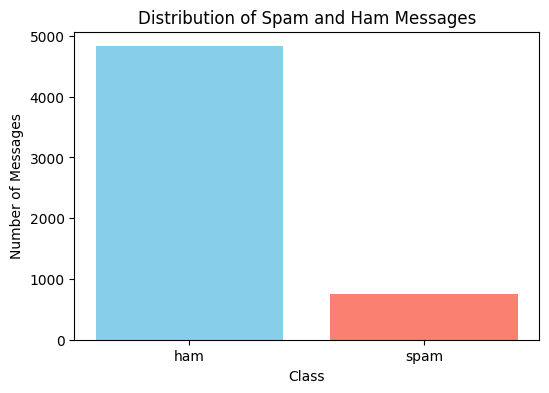

In [ ]:
# Count the occurrences of 'spam' and 'ham' labels
label_counts = defaultdict(int)
for label in labels:
    label_counts[label] += 1

# Create a bar plot to visualize the counts
classes = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(6, 4))
plt.bar(classes, counts, color=['skyblue', 'salmon'])
plt.xlabel('Class')
plt.ylabel('Number of Messages')
plt.title('Distribution of Spam and Ham Messages')
plt.show()

--- Starting 5-Fold Cross-Validation ---

--- Fold 1/5 ---
  Model: Multinomial NB
    Confusion Matrix: TP=140, TN=960, FP=5, FN=9
    Accuracy: 0.9874
    Precision: 0.9655
    Recall: 0.9396
    F1-Score: 0.9524

  Model: Bernoulli NB
    Confusion Matrix: TP=148, TN=846, FP=119, FN=1
    Accuracy: 0.8923
    Precision: 0.5543
    Recall: 0.9933
    F1-Score: 0.7115

--- Fold 2/5 ---
  Model: Multinomial NB
    Confusion Matrix: TP=134, TN=965, FP=4, FN=11
    Accuracy: 0.9865
    Precision: 0.9710
    Recall: 0.9241
    F1-Score: 0.9470

  Model: Bernoulli NB
    Confusion Matrix: TP=144, TN=822, FP=147, FN=1
    Accuracy: 0.8671
    Precision: 0.4948
    Recall: 0.9931
    F1-Score: 0.6606

--- Fold 3/5 ---
  Model: Multinomial NB
    Confusion Matrix: TP=129, TN=965, FP=7, FN=13
    Accuracy: 0.9820
    Precision: 0.9485
    Recall: 0.9085
    F1-Score: 0.9281

  Model: Bernoulli NB
    Confusion Matrix: TP=139, TN=823, FP=149, FN=3
    Accuracy: 0.8636
    Precision: 0.4826
    

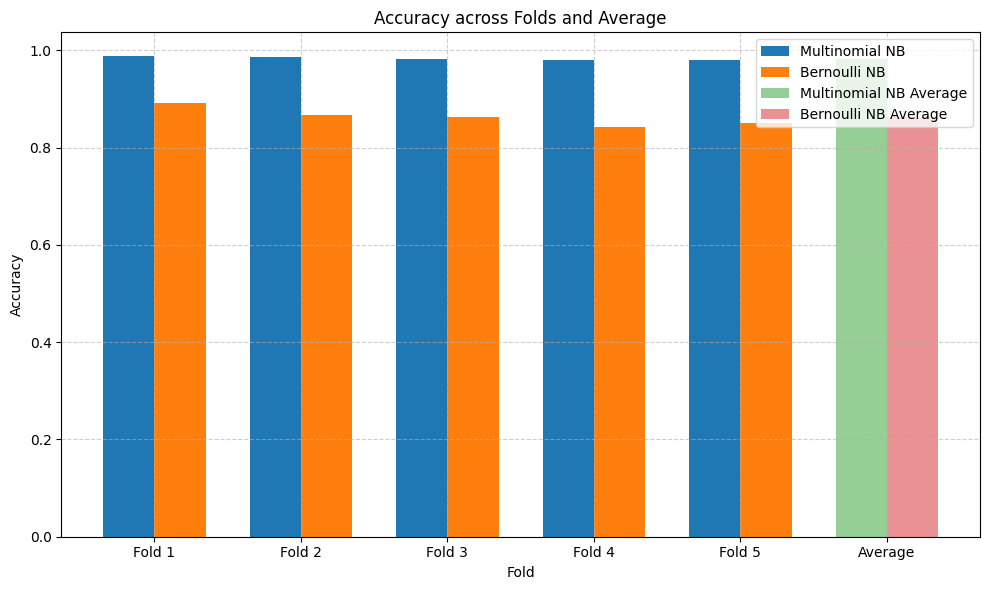

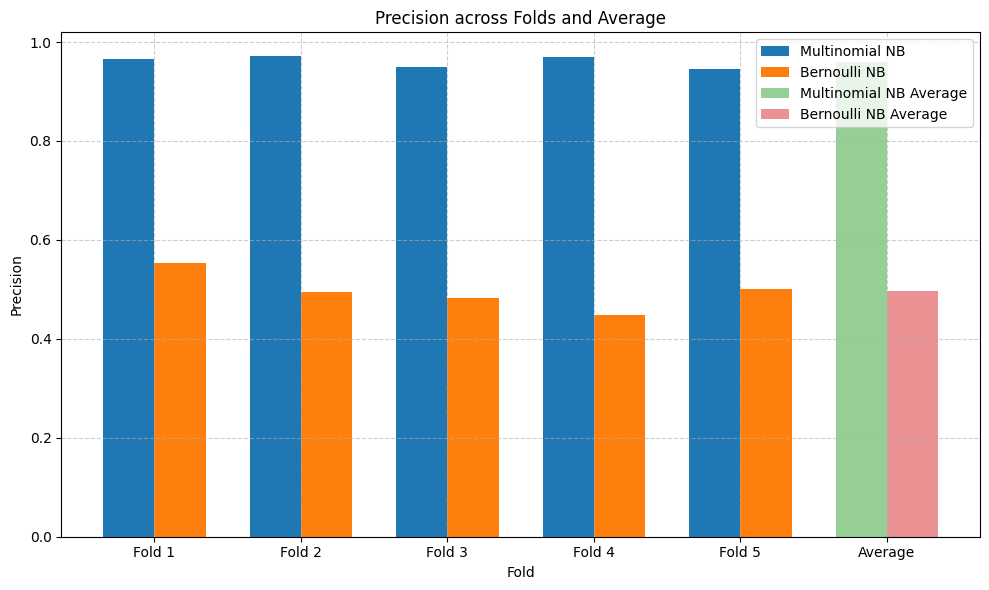

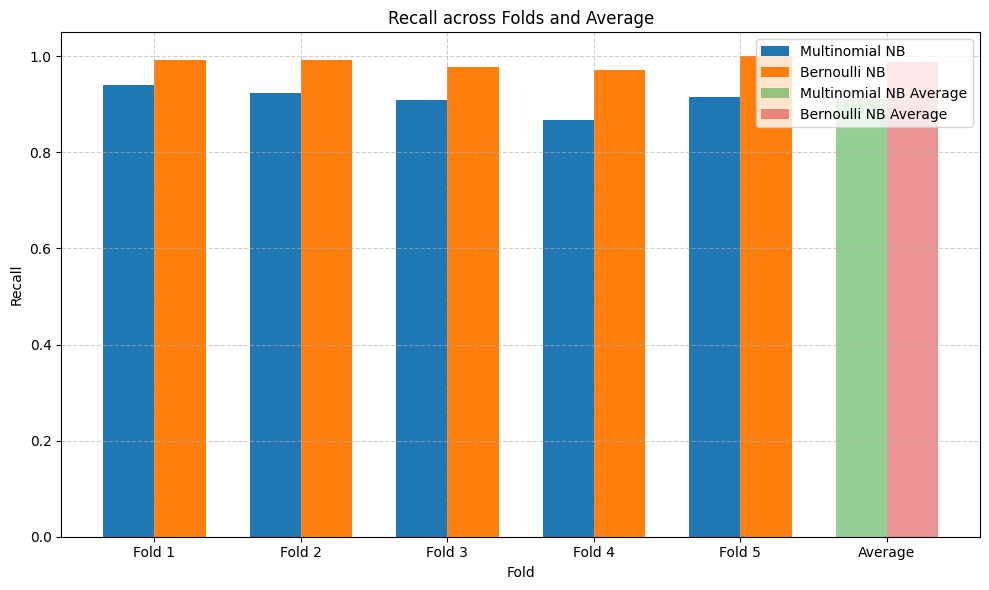

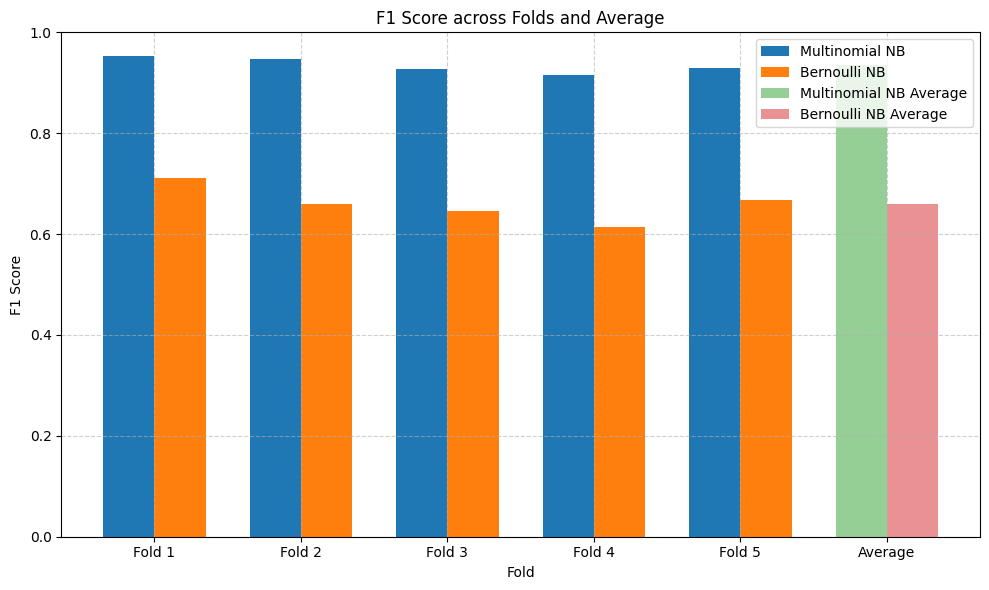

In [ ]:
# --- 4. Main Execution and Cross-Validation ---

def main():
    n_folds = 5 #
    fold_size = len(data) // n_folds

    models = {
        "Multinomial NB": MultinomialNB(),
        "Bernoulli NB": BernoulliNB()
    }

    results = {name: [] for name in models}

    print("--- Starting 5-Fold Cross-Validation ---\n")

    for i in range(n_folds):
        print(f"--- Fold {i+1}/{n_folds} ---")

        # Manual k-fold splitting
        start, end = i * fold_size, (i + 1) * fold_size
        X_test = texts[start:end]
        y_test = labels[start:end]
        X_train = np.concatenate((texts[:start], texts[end:]))
        y_train = np.concatenate((labels[:start], labels[end:]))

        for name, model in models.items():
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            metrics = calculate_metrics(y_test, predictions)
            results[name].append(metrics)

            print(f"  Model: {name}")
            cm = metrics['confusion_matrix']
            print(f"    Confusion Matrix: TP={cm['tp']}, TN={cm['tn']}, FP={cm['fp']}, FN={cm['fn']}")
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    Precision: {metrics['precision']:.4f}")
            print(f"    Recall: {metrics['recall']:.4f}")
            print(f"    F1-Score: {metrics['f1_score']:.4f}\n")

    print("\n--- Final Averaged Results ---") #

    # Print comparison table [cite: 46]
    print(f"{'Metric':<12} | {'Multinomial NB':<16} | {'Bernoulli NB':<16}")
    print("-" * 49)
    for metric_name in ['accuracy', 'precision', 'recall', 'f1_score']:
        avg_multi = np.mean([r[metric_name] for r in results['Multinomial NB']])
        avg_bern = np.mean([r[metric_name] for r in results['Bernoulli NB']])
        print(f"{metric_name.title():<12} | {avg_multi:<16.4f} | {avg_bern:<16.4f}")

    return results # Return the results dictionary

if __name__ == '__main__':
    cv_results = main()

def plot_metrics(results):
    """Generates bar plots for performance metrics across folds and their averages."""
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    models = list(results.keys())
    n_folds = len(results[models[0]])
    folds = [f'Fold {i+1}' for i in range(n_folds)]
    x = np.arange(n_folds) # the label locations

    for metric_name in metrics:
        fig, ax = plt.subplots(figsize=(10, 6))
        width = 0.35 # the width of the bars

        # Data for plotting
        metric_values = {model: [r[metric_name] for r in results[model]] for model in models}
        avg_metric_values = {model: np.mean(metric_values[model]) for model in models}

        # Plot fold results
        rects1 = ax.bar(x - width/2, metric_values[models[0]], width, label=models[0])
        rects2 = ax.bar(x + width/2, metric_values[models[1]], width, label=models[1])

        # Plot average results
        ax.bar(n_folds - width/2, avg_metric_values[models[0]], width, label=f'{models[0]} Average', alpha=0.5)
        ax.bar(n_folds + width/2, avg_metric_values[models[1]], width, label=f'{models[1]} Average', alpha=0.5)


        # Add some text for labels, title and axes ticks
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric_name.replace('_', ' ').title())
        ax.set_title(f'{metric_name.replace("_", " ").title()} across Folds and Average')
        ax.set_xticks(np.append(x, n_folds))
        ax.set_xticklabels(folds + ['Average'])
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

# Call the function with the results obtained from main()
plot_metrics(cv_results)

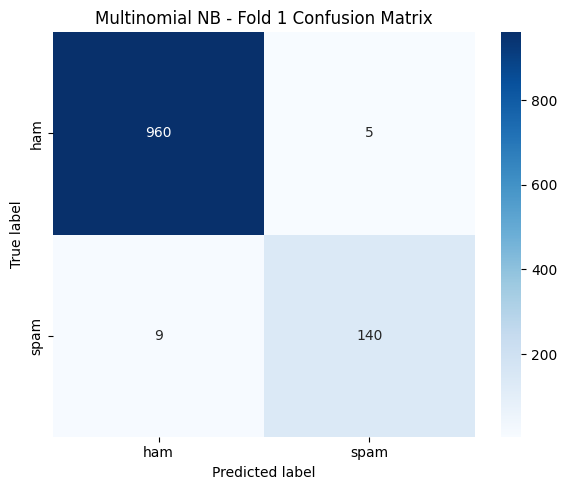

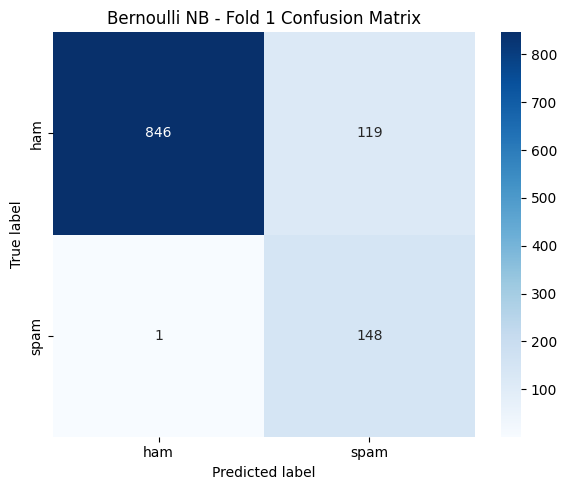

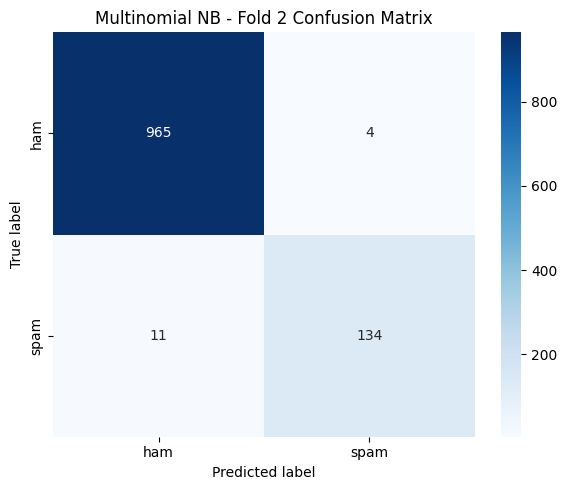

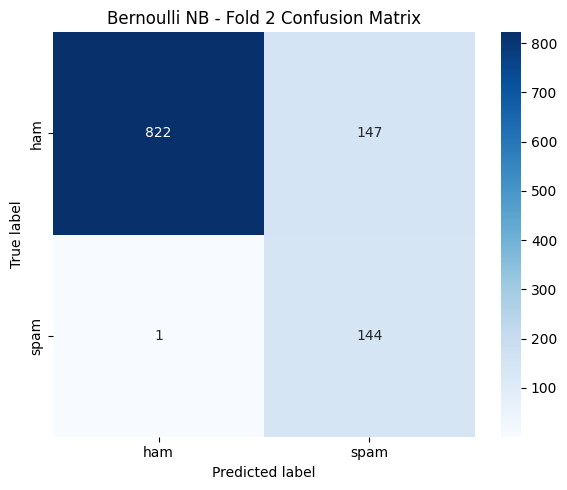

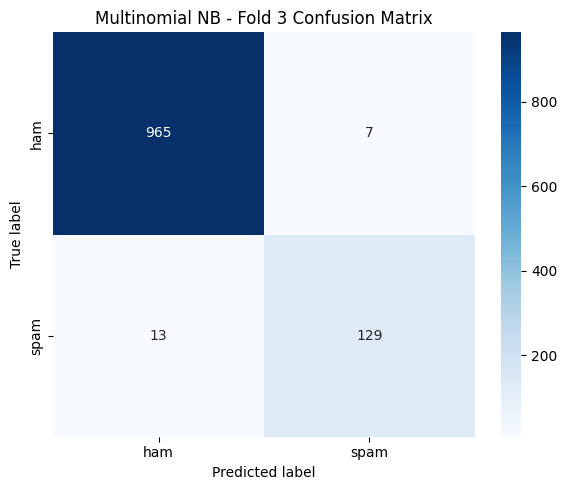

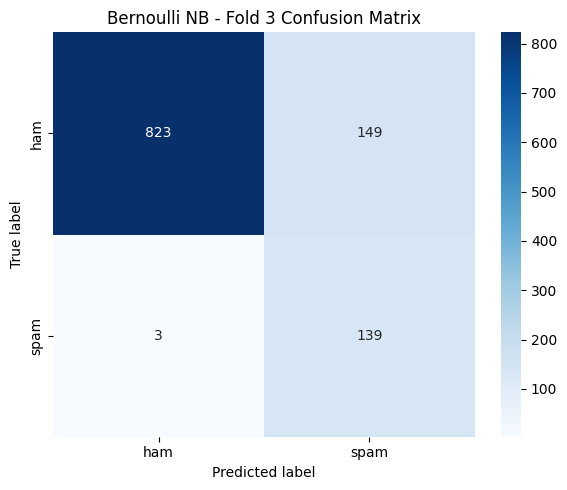

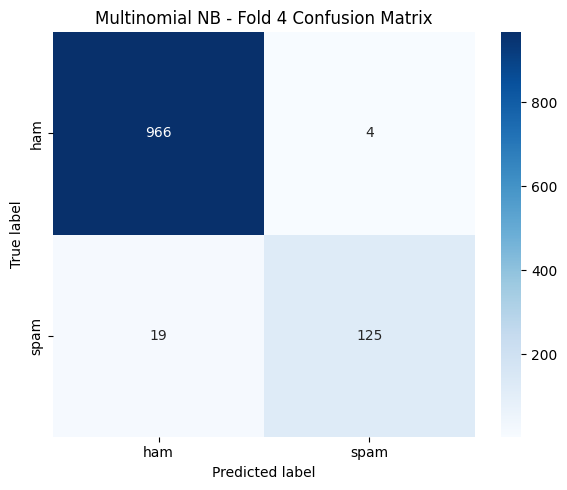

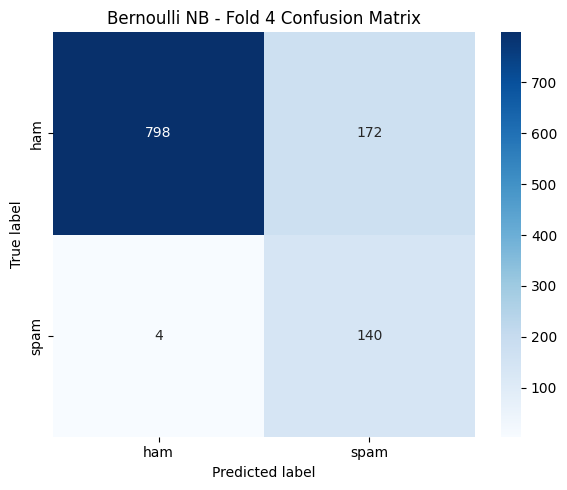

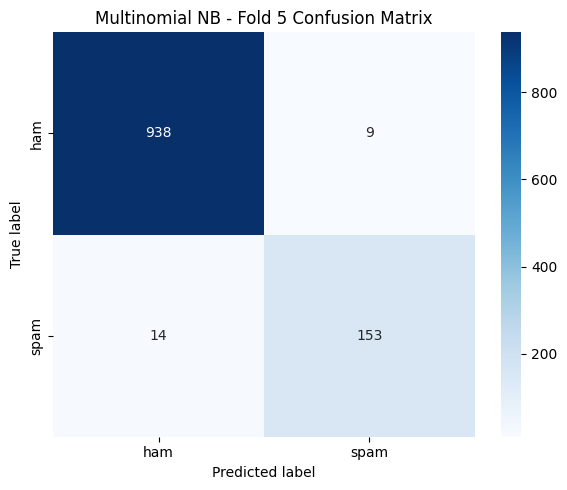

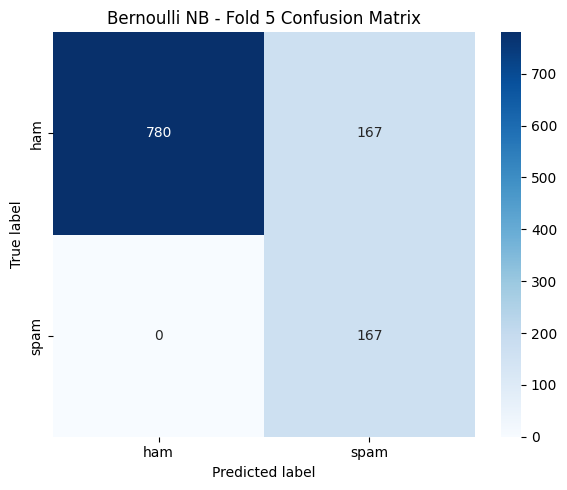

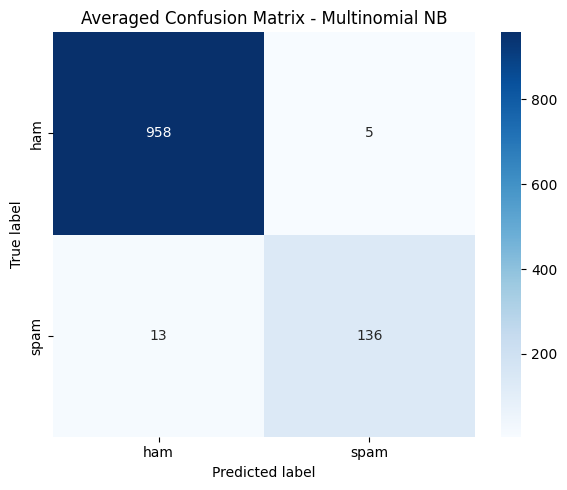

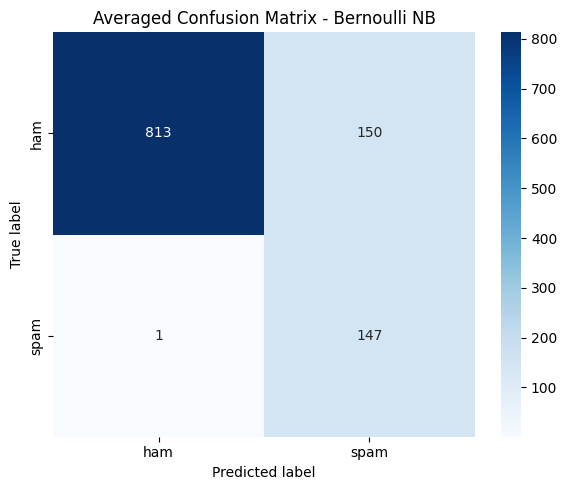

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

class_names = ['ham', 'spam']

# Plot confusion matrices for each fold
for fold_idx in range(len(cv_results['Multinomial NB'])):
    for model_name, results_list in cv_results.items():
        cm_data = results_list[fold_idx]['confusion_matrix']
        # Convert dictionary to a 2x2 numpy array for plotting
        cm_array = np.array([[cm_data['tn'], cm_data['fp']],
                             [cm_data['fn'], cm_data['tp']]])
        plot_confusion_matrix(cm_array, class_names, title=f'{model_name} - Fold {fold_idx+1} Confusion Matrix')

# Calculate and plot averaged confusion matrices
avg_cms = {name: defaultdict(float) for name in cv_results}

for model_name, results_list in cv_results.items():
    for fold_result in results_list:
        cm_data = fold_result['confusion_matrix']
        avg_cms[model_name]['tp'] += cm_data['tp']
        avg_cms[model_name]['tn'] += cm_data['tn']
        avg_cms[model_name]['fp'] += cm_data['fp']
        avg_cms[model_name]['fn'] += cm_data['fn']

n_folds = len(cv_results[list(cv_results.keys())[0]])

for model_name, avg_cm_data in avg_cms.items():
    avg_cm_array = np.array([[int(avg_cm_data['tn'] / n_folds), int(avg_cm_data['fp'] / n_folds)],
                             [int(avg_cm_data['fn'] / n_folds), int(avg_cm_data['tp'] / n_folds)]]) # Use int for displaying averaged counts as integers
    plot_confusion_matrix(avg_cm_array, class_names, title=f'Averaged Confusion Matrix - {model_name}')

In [ ]:
misclassified_examples = {name: {'FP': [], 'FN': []} for name in cv_results}

n_folds = len(cv_results[list(cv_results.keys())[0]])
fold_size = len(data) // n_folds

for i in range(n_folds):
    # Manual k-fold splitting (re-creating test set for this fold)
    start, end = i * fold_size, (i + 1) * fold_size
    # Use original texts before preprocessing to display the actual message
    X_test_original = np.array([d[1] for d in data])[start:end]
    y_test = np.array(labels)[start:end]

    for model_name, model in models.items(): # Access models dictionary from previous cells
        # Re-fit the model for this fold to get predictions
        X_train = np.concatenate((texts[:start], texts[end:]))
        y_train = np.concatenate((labels[:start], labels[end:]))
        model.fit(X_train, y_train)
        predictions = model.predict(texts[start:end]) # Predict using preprocessed texts

        # Identify misclassifications
        for j in range(len(y_test)):
            if predictions[j] != y_test[j]:
                if y_test[j] == 'ham' and predictions[j] == 'spam':
                    misclassified_examples[model_name]['FP'].append({
                        'message': X_test_original[j],
                        'true': y_test[j],
                        'predicted': predictions[j],
                        'fold': i + 1
                    })
                elif y_test[j] == 'spam' and predictions[j] == 'ham':
                    misclassified_examples[model_name]['FN'].append({
                        'message': X_test_original[j],
                        'true': y_test[j],
                        'predicted': predictions[j],
                        'fold': i + 1
                    })

# Display examples of misclassified messages
print("\n--- Examples of Misclassified Messages ---")

for model_name, errors in misclassified_examples.items():
    print(f"\nModel: {model_name}")
    print(f"  False Positives (Ham predicted as Spam): {len(errors['FP'])} examples")
    for i, example in enumerate(errors['FP'][:5]): # Display up to 5 examples
        print(f"    FP {i+1} (Fold {example['fold']}): True='{example['true']}', Predicted='{example['predicted']}'")
        print(f"      Message: \"{example['message']}\"")

    print(f"  False Negatives (Spam predicted as Ham): {len(errors['FN'])} examples")
    for i, example in enumerate(errors['FN'][:5]): # Display up to 5 examples
        print(f"    FN {i+1} (Fold {example['fold']}): True='{example['true']}', Predicted='{example['predicted']}'")
        print(f"      Message: \"{example['message']}\"")


--- Examples of Misclassified Messages ---

Model: Multinomial NB
  False Positives (Ham predicted as Spam): 29 examples
    FP 1 (Fold 1): True='ham', Predicted='spam'
      Message: "Ummma.will call after check in.our life will begin from qatar so pls pray very hard."
    FP 2 (Fold 1): True='ham', Predicted='spam'
      Message: "Imagine you finally get to sink into that bath after I have put you through your paces, maybe even having you eat me for a while before I left ... But also imagine the feel of that cage on your cock surrounded by the bath water, reminding you always who owns you ... Enjoy, my cuck"
    FP 3 (Fold 1): True='ham', Predicted='spam'
      Message: "sorry, no, have got few things to do. may be in pub later."
    FP 4 (Fold 1): True='ham', Predicted='spam'
      Message: "No da if you run that it activate the full version da."
    FP 5 (Fold 1): True='ham', Predicted='spam'
      Message: "From someone not to smoke when every time I've smoked in the last two wee

In [ ]:
misclassified_examples = {name: {'FP': [], 'FN': []} for name in cv_results}

n_folds = len(cv_results[list(cv_results.keys())[0]])
fold_size = len(data) // n_folds

# Redefine models dictionary
models = {
    "Multinomial NB": MultinomialNB(),
    "Bernoulli NB": BernoulliNB()
}


for i in range(n_folds):
    # Manual k-fold splitting (re-creating test set for this fold)
    start, end = i * fold_size, (i + 1) * fold_size
    # Use original texts before preprocessing to display the actual message
    X_test_original = np.array([d[1] for d in data])[start:end]
    y_test = np.array(labels)[start:end]

    for model_name, model in models.items(): # Access models dictionary from previous cells
        # Re-fit the model for this fold to get predictions
        X_train = np.concatenate((texts[:start], texts[end:]))
        y_train = np.concatenate((labels[:start], labels[end:]))
        model.fit(X_train, y_train)
        predictions = model.predict(texts[start:end]) # Predict using preprocessed texts

        # Identify misclassifications
        for j in range(len(y_test)):
            if predictions[j] != y_test[j]:
                if y_test[j] == 'ham' and predictions[j] == 'spam':
                    misclassified_examples[model_name]['FP'].append({
                        'message': X_test_original[j],
                        'true': y_test[j],
                        'predicted': predictions[j],
                        'fold': i + 1
                    })
                elif y_test[j] == 'spam' and predictions[j] == 'ham':
                    misclassified_examples[model_name]['FN'].append({
                        'message': X_test_original[j],
                        'true': y_test[j],
                        'predicted': predictions[j],
                        'fold': i + 1
                    })

# Display examples of misclassified messages
print("\n--- Examples of Misclassified Messages ---")

for model_name, errors in misclassified_examples.items():
    print(f"\nModel: {model_name}")
    print(f"  False Positives (Ham predicted as Spam): {len(errors['FP'])} examples")
    for i, example in enumerate(errors['FP'][:5]): # Display up to 5 examples
        print(f"    FP {i+1} (Fold {example['fold']}): True='{example['true']}', Predicted='{example['predicted']}'")
        print(f"      Message: \"{example['message']}\"")

    print(f"  False Negatives (Spam predicted as Ham): {len(errors['FN'])} examples")
    for i, example in enumerate(errors['FN'][:5]): # Display up to 5 examples
        print(f"    FN {i+1} (Fold {example['fold']}): True='{example['true']}', Predicted='{example['predicted']}'")
        print(f"      Message: \"{example['message']}\"")


--- Examples of Misclassified Messages ---

Model: Multinomial NB
  False Positives (Ham predicted as Spam): 29 examples
    FP 1 (Fold 1): True='ham', Predicted='spam'
      Message: "Ummma.will call after check in.our life will begin from qatar so pls pray very hard."
    FP 2 (Fold 1): True='ham', Predicted='spam'
      Message: "Imagine you finally get to sink into that bath after I have put you through your paces, maybe even having you eat me for a while before I left ... But also imagine the feel of that cage on your cock surrounded by the bath water, reminding you always who owns you ... Enjoy, my cuck"
    FP 3 (Fold 1): True='ham', Predicted='spam'
      Message: "sorry, no, have got few things to do. may be in pub later."
    FP 4 (Fold 1): True='ham', Predicted='spam'
      Message: "No da if you run that it activate the full version da."
    FP 5 (Fold 1): True='ham', Predicted='spam'
      Message: "From someone not to smoke when every time I've smoked in the last two wee

## Summary:

### Data Analysis Key Findings

* The dataset exhibits a significant class imbalance, with considerably more 'ham' (non-spam) messages than 'spam' messages.
* The Multinomial Naive Bayes classifier consistently outperformed the Bernoulli Naive Bayes classifier across most metrics, including accuracy, precision, and F1-score, based on the average results from 5-fold cross-validation.
* Multinomial Naive Bayes achieved an average accuracy of approximately 0.9835, a high average precision of about 0.9591, and an F1-score of about 0.9368.
* Bernoulli Naive Bayes had a significantly lower average accuracy (approximately 0.8585), a much lower average precision (about 0.4872), and a lower F1-score (about 0.6523).
* Bernoulli Naive Bayes had a slightly higher average recall (approximately 0.9879) compared to Multinomial Naive Bayes (0.9160), indicating it was better at identifying actual spam, but at the cost of many false positives.
* Confusion matrix analysis confirmed that the Bernoulli Naive Bayes classifier had a very high number of False Positives, frequently misclassifying legitimate messages as spam.
* Multinomial Naive Bayes showed a much better balance in the confusion matrices, with fewer False Positives and False Negatives overall compared to Bernoulli NB.

### Insights or Next Steps

* Given the superior performance across key metrics, especially precision and F1-score, the Multinomial Naive Bayes classifier is the more suitable choice for this spam detection task.
* Further investigation into the types of messages misclassified by the Multinomial Naive Bayes (False Negatives) could help refine the model or preprocessing steps to improve the detection of subtle spam.